# Lightweight Transformer-based Model for Handwritten Character Recognition 
(https://hal.science/hal-03685976/file/A_Light_Transformer_Based_Architecture_for_Handwritten_Text_Recognition.pdf)

## ***note: Has a CNN backbone***

-----------

## Architecture  
Build up with a double Transformer architecture:  
- Image transformer as encoder: Extracts the visual features
- Text transformer as decoder: Language modeling, generates word-sections
             sequence using visual features and previous predictions

### Encoder:  
- CNN Backbone (5 convolutions)
- Sinusodial position encoding  
- 4 layer transformer layer encoder

### Decoder: 
- Takes encoder output and along with sequence of previously predicted characters
- Additional loss in the middle of the network to help convergence

### Hybrid loss:
- CTC and CE Loss combined, CTC on intermediate encoder output, CE on decoder output

--------------


## Start pipeline

In [1]:
import sys
import os

from collections import OrderedDict, Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision.io import read_image

import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Constants

In [2]:
DATA_PATH = f"/home/hkolstee/uniprojects/DATA/HWR/IAM-data/IAM-data/"
TRAIN_TEST_SPLIT = 0.2
BATCH_SIZE = 64
INPUT_HEIGHT = 128
# input width -> largest width in batch
#   images max resized and subsequently padded to get to width
EPOCHS = 500

### Prepare Data

In [3]:
raw_data = pd.read_fwf(DATA_PATH + "iam_lines_gt.txt", header = None)
raw_data = raw_data.values.tolist()

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


an Italian who is perhaps the best Valet de Chambre


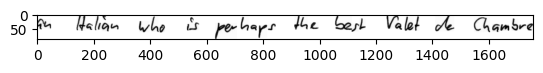

In [4]:
# example
ex_label = "an Italian who is perhaps the best Valet de Chambre" 
print(ex_label)
# print(data['labels'][0])
image = read_image(os.path.join(DATA_PATH, "img", "g06-026i-01.png"))
plt.imshow(image[0, :, :], cmap = "gray")

first, we need the input/image width we have to resize the images to.  
This is the largest image width in the entire batch of images (source paper randomly added/removed new augments each training epoch).   
For now we just take the largest width in the original images.  
  
The labels are later padded to the largest label size in the dataset, such that we also need to know the longest label size.

In [5]:
def getBiggestWidth(data: pd.DataFrame):
    biggest_width = 0

    for index in range(len(data['img_names'])):
        image_path = os.path.join(DATA_PATH, "img", data['img_names'][index])
        image = read_image(image_path)
        
        if (image.size(2) > biggest_width):
            biggest_width = image.size(2)

    return biggest_width

def getLongestLabel(data: pd.DataFrame):
    longest = 0
    
    for index in range(len(data['labels'])):
        if (len(data['labels'][index]) > longest):
            longest = len(data['labels'][index])
            
    return longest

Biggest width needed to pad all images to this width for the input into the encoder.  
Longest label needed to pad all labels to this length for the input into the decoder.

In [6]:
input_width = getBiggestWidth(data)
print(input_width)

longest_label = getLongestLabel(data)
# <BOS> and <EOS> tokens not counted
longest_label += 2
print(longest_label)

2260
56


### TODO: Data augmentation

### Resize and pad images to largest width in dataset  
### ***NOTE: Not sure if padding should be all at the right part of the image or both sides***

In [7]:
# resizes to largest width in batch x 128, keeping aspect ratio and padding image
def resizeImage(image, resize_width, resize_height):
    # check if resizing to correct height while keeping aspect ratio does not overshoot correct width
    aspect_ratio_width = int((resize_height / image.size(1)) * image.size(2))
    if (aspect_ratio_width > resize_width):
        # calculate max ratio of change for not overshooting resize width while keeping aspect ratio 
        max_ratio = resize_width / image.size(2)
        max_resize_height = int(max_ratio * image.size(1))
        # calc up and down padding
        padding_up = int(((resize_height - max_resize_height) / 2))
        padding_down = resize_height - max_resize_height - padding_up
        # change resize height to max calculated resize height
        resize_height = max_resize_height
    else:
        padding_up = 0
        padding_down = 0

    # resize to correct image height, while keeping aspect ratio
    resize_transform = tv.transforms.Resize((resize_height, resize_width), antialias = True)
    resized = resize_transform(image)
    
    # pad to correct width (and height if necessary)
    padding_left = int(((resize_width - resized.size(2)) / 2))
    padding_right = resize_width - resized.size(2) - padding_left
    resized_padded = F.pad(resized, (padding_left, padding_right, padding_up, padding_down), mode = "constant", value = 255)

    return resized_padded


This example because it previously overshot the correct width using the height measurements for the aspect ratio.

an Italian who is perhaps the best Valet de Chambre
torch.Size([1, 86, 1758])
torch.Size([1, 128, 2260])
torch.uint8


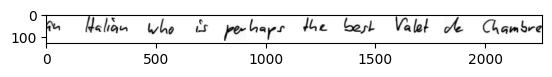

In [8]:
print(ex_label)
image = read_image(os.path.join(DATA_PATH, "img", "g06-026i-01.png"))
print(image.shape)

resized_image = resizeImage(image, input_width, INPUT_HEIGHT)
plt.imshow(resized_image[0, :, :], cmap = "gray")
print(resized_image.shape)
print(resized_image.dtype)

Resize and pad for the whole dataset and save in a new dir such that we don't have to do this each epoch. TODO

### Train test split

In [9]:
train, test = train_test_split(data, test_size = TRAIN_TEST_SPLIT)

# reset indices from current random state
train.reset_index(inplace = True)
test.reset_index(inplace = True)

### Create custom pytorch dataset


For character level embedding (decoder input) we find out how many characters are present in the dataset. By counting the characters we give the most common characters the lowest indices

In [10]:
# returns a dict of uniques chars sorted on how common they are in the dataset labels
def uniqueCharsByMostCommon(data: pd.DataFrame):
    sortedDict = OrderedDict(Counter(''.join(data['labels'].values)).most_common())
    newDict = {}
    
    # first add pad, begin of sentence, and end of sentence tokens
    newDict["<PAD>"] = 0
    newDict["<BOS>"] = 1
    newDict["<EOS>"] = 2
    
    for idx, char in enumerate(sortedDict):
        newDict[char] = idx + 3
    
    return newDict

In [11]:
# get mapping before splitting dataset
char_to_idx_mapping = uniqueCharsByMostCommon(data)
char_to_idx_mapping

{'<PAD>': 0,
 '<BOS>': 1,
 '<EOS>': 2,
 ' ': 3,
 'e': 4,
 't': 5,
 'a': 6,
 'o': 7,
 'n': 8,
 'i': 9,
 's': 10,
 'r': 11,
 'h': 12,
 'l': 13,
 'd': 14,
 'c': 15,
 'u': 16,
 'm': 17,
 'f': 18,
 'p': 19,
 'w': 20,
 'g': 21,
 'y': 22,
 'b': 23,
 '.': 24,
 ',': 25,
 'v': 26,
 'k': 27,
 "'": 28,
 '"': 29,
 '-': 30,
 'T': 31,
 'I': 32,
 'M': 33,
 'A': 34,
 'S': 35,
 'B': 36,
 'P': 37,
 'H': 38,
 'W': 39,
 'C': 40,
 'N': 41,
 'G': 42,
 'x': 43,
 'R': 44,
 'L': 45,
 'E': 46,
 'D': 47,
 'F': 48,
 '0': 49,
 '1': 50,
 'j': 51,
 'O': 52,
 'q': 53,
 '!': 54,
 'U': 55,
 '(': 56,
 'K': 57,
 '?': 58,
 'z': 59,
 '3': 60,
 ')': 61,
 '9': 62,
 ';': 63,
 'V': 64,
 '2': 65,
 'J': 66,
 'Y': 67,
 ':': 68,
 '5': 69,
 '8': 70,
 '4': 71,
 '6': 72,
 '#': 73,
 '&': 74,
 '7': 75,
 '/': 76,
 'Q': 77,
 'X': 78,
 '*': 79,
 'Z': 80,
 '+': 81}

In [12]:
class HandWritingDataset(Dataset):
    def __init__(self, data: pd.DataFrame, data_path, img_width, img_height, char_to_idx_mapping: dict, max_label_size):
        self.data = data
        self.data_path = data_path
        self.img_width = img_width
        self.img_height = img_height
        self.label_size = max_label_size

        self.char_to_idx_mapping = char_to_idx_mapping
        self.idx_to_char_mapping = {value: key for key, value in self.char_to_idx_mapping.items()}

        self.createLabelEncodings()
        self.reshapeAndStoreImages()

        # calc mean and std of images combines for standardization
        mean, std = self.calcImagesMeanStd()
        # normalize transform (used when indexing image)
        self.normalize = tv.transforms.Normalize(mean, std)

    def createLabelEncodings(self):
        # change character level strings to embed indices 
        #   (embedding itself calculated in forward pass)
        self.labels_as_idxs = [torch.tensor([[self.char_to_idx_mapping[char]] for char in label]) for label in data['labels']]   
        # add <EOS> tokens at the end of sentences
        self.labels_as_idxs = [torch.cat([label, torch.tensor([[self.char_to_idx_mapping['<EOS>']]])]) for label in self.labels_as_idxs]
        # input into decoder shifted right (while training) and <BOS> token inserted at start
        self.decoder_input_as_idxs = [torch.cat([torch.tensor([[self.char_to_idx_mapping['<BOS>']]]), label]) for label in self.labels_as_idxs]
        
        # pad labels embedding indices to largest label length with <PAD> token
        self.labels_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']) \
                               for label in self.labels_as_idxs]
        
        # pad decoder input char embedding indices to largest label length with <PAD> tokens 
        self.decoder_input_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']) \
                               for label in self.decoder_input_as_idxs]
        
        # transform target labels into one hot encoding vectors
        self.labels_as_onehot =  [F.one_hot(label, num_classes = len(self.char_to_idx_mapping)) for label in self.labels_as_idxs]        

    # reshapes + pads the images to the correct input width and height
    def reshapeAndStoreImages(self):
        self.images = []

        for image_name in self.data['img_names']:
            # read image
            image = read_image(os.path.join(self.data_path, "img", image_name))
            # resize + pad image to correct input size
            resized_padded = resizeImage(image, self.img_width, self.img_height)
            # store in list of tensors
            self.images.append(resized_padded)

            
    # Function to calc the mean and std of a dataset to use in image standardization 
    def calcImagesMeanStd(self):
        running_mean = 0
        running_std = 0

        for image in self.images:
            mean = torch.mean(image.float())
            std = torch.std(image.float())

            running_mean += mean
            running_std += std

        return (running_mean / len(self.images)), (running_std / len(self.images))
    
    # transforms done in __getitem__ so that images can be stored as Byte tensors (-> less memory and kernel does not crash)
    def __getitem__(self, index):
        # image
        image = self.images[index].float()
        # standardize image
        image = self.normalize(image)
        # paper adds gaussian noise to image (sqrt(0.1) * rand from gaussian distri)
        image += ((0.1**0.5) * torch.randn(image.shape)) * 0.75

        # label
        label = self.labels_as_onehot[index]
        # label shifted right
        decoder_in = self.decoder_input_as_idxs[index]

        # image = tensor, label = one hot encoded target characters, decoder_in = label shifted right as indices for embedding table
        return image, label, decoder_in

    def __len__(self):
        # return length of column
        return len(self.data)

Create datasets and dataloaders

In [13]:
# datasets
train_set = HandWritingDataset(train, DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label)
test_set = HandWritingDataset(test, DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label)

# dataloaders
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)

### Model 

Sinusodial positional encoding  
(can be changed to nn.embedding layers if we don't get good results, however that is not exactly sinusodial pos encoding like in the paper I think)

<!-- **CHANGED TO NN.EMBEDDING IN MODEL**   -->

In [ ]:
class SinPosEncoding(nn.Module):
    def __init__(self, dimensionality):
        super(SinPosEncoding, self).__init__()
        self.dims = dimensionality
        self.max_len = 1000

        # position vector
        positions = torch.arange(0, self.max_len).unsqueeze(1)
        # calculate added angle for sin/cos
        angle = torch.exp(torch.arange(0, self.dims, 1) * (-np.log(10000.0) / self.dims))

        # initialize the 2D positional encodings array
        pos_encodings = torch.zeros(self.max_len, 1, self.dims)
        # calucalte encodings
        pos_encodings = torch.sin(positions * angle)
        # pos_encodings[:, 0, :] = torch.sin(positions * angle)

        # add to buffer for training performance (?)
        self.register_buffer('pos_encodings', pos_encodings)

    
    def forward(self, input: torch.Tensor):
        print("\n", input.shape)
        print(self.pos_encodings.shape)
        # adds the positional encoding elementwise to the tensor (seqlength, batch, embeddims)
        input += self.pos_encodings[0:input.size(1)]
        print("succes\n")

        return input

Model architecture

In [ ]:
class HWRTransformer(nn.Module):
    def __init__(self, input_width, input_height, total_nr_of_tokens, longest_label):
        super(HWRTransformer, self).__init__()
        # generate target mask for decoder (can be reused as target sequences are padded to same length (probably?))
        self.target_mask = self.make_target_mask(longest_label)

        # convolutional block (5 convolutions)
        # first convolution
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3))
        width = input_width - 2
        height = input_height - 2
        self.leakyRelu = nn.LeakyReLU()     # reuse in later layers
        self.maxPool = nn.MaxPool2d((2,2))  # reuse in later layers
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm1 = nn.LayerNorm(normalized_shape = [8, height, width])
        self.dropout = nn.Dropout(0.2)      # reuse in later layers

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm2 = nn.LayerNorm(normalized_shape = [16, height, width])


        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm3 = nn.LayerNorm(normalized_shape = [32, height, width])

        # forth convolutional layer
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # no maxpool
        self.layerNorm4 = nn.LayerNorm(normalized_shape = [64, height, width])

        # fifth convolutional layer (kernel size to better match shape of character)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 2))
        width -= 1
        height -= 3
        # no maxpool
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, height, width])

        # following is convolution with width 1 which is used to flatten the current output
        self.flattenConv = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (height, 1))
        self.layerNorm6 = nn.LayerNorm(normalized_shape = [128, 1, width])

        # dense layer to upscale from 128 to 256
        self.dense1 = nn.Linear(in_features = 128, out_features = 256)
        # sinusoidal positional encoding is added to the output of the dense layer
        self.encoder_pos_encoding = SinPosEncoding(dimensionality = 256)

        # transformer encoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_encoder1 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder2 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder3 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder4 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        # dense layer for backprop CTC Loss of intermediate encoder result
        self.encoder_out_dense = nn.Linear(256, total_nr_of_tokens)

        # Here starts: decoder
        # character embedding (dim rule of thumb -> 4th sqrt of nr_embeddings: for ~80 = 3) 
        #      NOTE: wrong, appearantly dims (encoder output, target embedding) need to be the same
        # <PAD> embedding idx = 0
        self.char_embedding = nn.Embedding(total_nr_of_tokens, 256, padding_idx = 0)
        # positional embedding of decoder input sequence
        self.decoder_pos_encoding = SinPosEncoding(dimensionality = 256)

        # transformer decoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_decoder1 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder2 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder3 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder4 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        self.decoder_out_dense = nn.Linear(256, total_nr_of_tokens)
    
    # create a target mask for decoder input
    #   masks the future target characters from being seen by the model before they should
    def make_target_mask(self, size):
        mask = torch.zeros((size, size), dtype = torch.float32)
        
        for i in range(size):
            for j in range(size):
                if (j > i):
                    mask[i][j] = float('-inf')
        return mask
    
    # first forward call: interm_outputs shoudl be a tensor with the embedding of <BOS>
    def forward(self, input_img, decoder_in_idxs):
        # through 5 convolutional layers
        # first conv
        print("start forward")
        encoder_out = self.layerNorm1(self.maxPool(self.leakyRelu(self.conv1(input_img))))
        encoder_out = self.dropout(encoder_out)
        # second conv
        encoder_out = self.layerNorm2(self.maxPool(self.leakyRelu(self.conv2(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # third conv
        encoder_out = self.layerNorm3(self.maxPool(self.leakyRelu(self.conv3(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # forth conv
        encoder_out = self.layerNorm4(self.leakyRelu(self.conv4(encoder_out)))
        # fifth conv
        encoder_out = self.layerNorm5(self.leakyRelu(self.conv5(encoder_out)))

        # flatten layer
        encoder_out = self.layerNorm6(self.leakyRelu(self.flattenConv(encoder_out)))

        # dense layer (activation function not mentioned in paper) 
        # needs reshaped tensor where dims are reversed ((batch, 128, 1, x) -> (batch, x, 1, 128))
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(0), encoder_out.size(3), encoder_out.size(2), encoder_out.size(1)))
        encoder_out = self.dense1(encoder_out)

        print("conv out succes")

        # add sinusodial positional information
        # needs reshape (batch, seq_len, 1, 256) -> (seq_len, batch, 256)  
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(1), encoder_out.size(0), encoder_out.size(3)))
        encoder_out = self.encoder_pos_encoding(encoder_out)

        print("pos encoding conv out succes")
        print(encoder_out.shape)
        # encoder_out = encoder_out[:, 0, :]
        # encoder_out = torch.reshape(encoder_out, (encoder_out.size(0), 1, encoder_out.size(1)))
        # print(encoder_out.shape)
        

        # transformer encoder layers
        encoder_out = self.trans_encoder1(encoder_out)
        encoder_out = self.trans_encoder2(encoder_out)
        encoder_out = self.trans_encoder3(encoder_out)
        encoder_out = self.trans_encoder4(encoder_out)

        print("encoder out succes")

        # dense layer for intermediate output of decoder (CTC Loss)
        interm_encoder_out = self.encoder_out_dense(encoder_out)

        print("encoder dense out succes")

        # add sinusodial positional information again
        encoder_out = self.encoder_pos_encoding(encoder_out)

        print("pos encoding encoder out succes")
        # target sequence (shifted right (so with <BOS> token))
        # print(self.char_embedding)
        decoder_in = self.char_embedding(decoder_in_idxs)
        # sys.exit()
        
        print("char embedding succes")

        # add sinusoidal positional information to decoder input
        decoder_in = self.decoder_pos_encoding(decoder_in)
        
        print("pos encoding decoder in succes")

        # input encoder output and predicted chars into decoder
        decoder_out = self.trans_decoder1(decoder_in, encoder_out, self.target_mask)
        decoder_out = self.trans_decoder2(decoder_out, encoder_out, self.target_mask)
        decoder_out = self.trans_decoder3(decoder_out, encoder_out, self.target_mask)
        decoder_out = self.trans_decoder4(decoder_out, encoder_out, self.target_mask)

        print("decoder out succes")

        # dense layer after decoder to predict one of all tokens (CE Loss)
        decoder_out = self.decoder_out_dense(decoder_out)

        print("decoder dense out succes")

        return interm_encoder_out, decoder_out

### Initialize transformer model

In [ ]:
hwr_transformer = HWRTransformer(input_width, INPUT_HEIGHT, len(char_to_idx_mapping), longest_label)

### Test with one image

Label text:
-> side. 'Old fashioned fivers!' he muttered again, and
image tensor shape:
-> torch.Size([1, 128, 2260])
one hot label shape:
-> torch.Size([56, 1, 82])
label shifted right embedding index tensor shape:
-> torch.Size([56, 1])
conv out succes

 torch.Size([277, 1, 256])
torch.Size([1000, 256])
succes

pos encoding conv out succes
torch.Size([277, 1, 256])
torch.Size([277, 1, 256])
encoder out succes
encoder dense out succes

 torch.Size([277, 1, 256])
torch.Size([1000, 256])
succes

pos encoding encoder out succes
char embedding succes

 torch.Size([56, 1, 256])
torch.Size([1000, 256])
succes

pos encoding decoder in succes
decoder out succes
decoder dense out succes

Shape of output of encoder (CTC Loss):
-> torch.Size([277, 1, 82])
Shape of decoder output (CE Loss):
-> torch.Size([56, 1, 82])


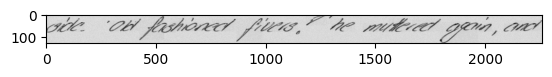

In [ ]:
# test image as tensor, test label as one hot encoded target characters, labels shifted right as indices for embedding table
test_image, test_label_one_hot, label_shifted_right_idxs = train_set[2]
print("Label text:\n->", train_set.data['labels'][2])
print("image tensor shape:\n->", test_image.shape)
print("one hot label shape:\n->", test_label_one_hot.shape)
# torch.set_printoptions(threshold=10000)
# print(test_label_one_hot)
print("label shifted right embedding index tensor shape:\n->", label_shifted_right_idxs.shape)

# create "batch" with single image
test_image_batch = test_image.unsqueeze(0)

plt.imshow(test_image_batch[0, 0, :, :], cmap = "gray")

# test label = <BOS> *sentence in tokens* <EOS> <PAD> <PAD> ... 
out1, out2 = hwr_transformer(test_image_batch, label_shifted_right_idxs)
print("\nShape of output of encoder (CTC Loss):\n->", out1.shape)
print("Shape of decoder output (CE Loss):\n->", out2.shape)

### Define hybrid loss

In [ ]:
class HybridLoss(nn.Module):
    def __init__(self, balance):
        super(HybridLoss, self).__init__()
        # allignment probabilities over encoded input sequence and target sequence 
        self.interm_CTCloss = nn.CTCLoss()
        # difference between decodeced input sequence and target sequence
        self.output_CELoss = nn.CrossEntropyLoss()

        # balance between CTC Loss and CE Loss (R: [0, 1])
        if balance < 0 or balance > 1:
            raise ValueError("Balance should be a value between 0 (only output CELoss) and 1 (only intermediate CTCLoss)")
        self.balance = balance

    def setBalance(self, balance):
        self.balance = balance

    def forward(self, encoder_output, encoder_target, decoder_output, decoder_target):
        interm_loss = self.interm_CTCloss(encoder_output, encoder_target)
        output_loss = self.output_CELoss(decoder_output, decoder_target)
        
        return (self.balance * interm_loss + (1 - self.balance) * output_loss)

In [ ]:
# in the paper they only used balance to test efficiousness of the hybrid loss, 
#   and train with a balance of 0.5
hybrid_loss_func = HybridLoss(0.5)

### Define optimizer

In [ ]:
optimizer = optim.Adam(hwr_transformer.parameters(), lr = 0.0001)

### Define train loop

In [ ]:
def train(model, train_loader, test_loader, loss_func, optim, epochs):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        running_loss_train = 0 
        running_loss_test = 0
        
        # train
        for i, data in enumerate(train_loader):
            # batched inputs (encoder = images, decoder = labels_shifted_rigth) and labels
            images, one_hot_labels, label_shifted_right_idxs = data
            
            # zero gradients before any calculations
            optimizer.zero_grad()
            
            # predict
            print(images.shape, label_shifted_right_idxs.shape)
            interm_outputs, decoder_outputs = model(images, label_shifted_right_idxs)
            
            # TODO: calc loss 
            # loss = loss_func()
            
            # take step along loss gradients
            # optimizer.step()
            
            # add to running loss
            # running_loss_train += loss.item()
        
        # test
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                # batched inputs (encoder = images, decoder = labels_shifted_rigth) and labels
                images, one_hot_labels, label_shifted_right_idxs = data
                
                # predict
                interm_outputs, decoder_outputs = model(images, label_shifted_right_idxs)
                
                # TODO: calc loss 
                # loss = loss_func()
                
                # add to running loss
                # running_loss_test += loss.item()
            
        # add to loss value lists
        # train_losses.append(running_loss_train / len(train_loader))
        # test_losses.append(running_loss_test / len(test_loader))
        
    # return train_losses, test_losses

### Train the model

In [ ]:
train(hwr_transformer, train_loader, test_loader, hybrid_loss_func, optimizer, EPOCHS)

torch.Size([64, 1, 128, 2260]) torch.Size([64, 56, 1])


: 

: 